<a href="https://colab.research.google.com/github/Mamoro98/Gen-AI/blob/main/Gen_AI_notebook_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 0**

Hi everyone!

This is notebook 0, which is mainly here to make sure that

1. You can get a colab notebook to run;
2. Familiarize you with PyTorch;
3. You can find a team-mate for the other notebooks.


## **CPUs and GPUs**

First, we need to connect to the GPU.

You might wonder: how and why do we use a GPU? The very short answer is the following. As you have seen in your earlier ML/DL course, neural networks are basically a composition of matrix multiplication and simple entry-wise functions. These matrix multiplication can map from very high dimensional spaces into very high dimensional spaces, and as such computing each resulting 'entry' would be extremely slow sequentially.

Now, a typical PC has two primary computations devices: a CPU and a GPU. They have (sort of) oposite functionality: a CPU is build to do **difficult computations sequentially**, whereas a GPU is build to do **easy computations in parallel**. As such, GPUs lend themselves perfectly do speed up deep learning computations!

Let's connect to the GPU. To do so, please:
- In the top right, click 'Connect', and hit 'Connect to a hosted runtime'.
- Then, go back in the menu, and hit 'change runtime type. There, make sure to select the GPU.
- Then, run the code above. There, we import PyTorch and choose the 'GPU' as our device to compute on.

In [ ]:
import torch
device = torch.device('cuda')  # 'cuda' here means GPU

In [ ]:
device

device(type='cuda')

## **Import our Data**

Ok! Now; we will load our data. We will use MNIST, which is a classical dataset consisting of images of digits. This we can grab from the torchvision library.

In [ ]:
import torchvision

# Here, we import both the train and test data. The library already made that
# split for us, and made sure the sets are disjoint. We add a 'ToTensor()'
# transform, so it changes from an 'image' to a 'matrix'.
train_dataset = torchvision.datasets.MNIST('dataset/', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST('dataset/', train=False, download=True, transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.35MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.38MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Now, we need to create 'dataloaders'. Dataloaders are a tool that take in a dataset, and let's us 'loop over it' by randomly dividing into small batches. As such, we can find a balance between not using all data at the same time (that is too expensive anyway!) but not too few to have very noisy updates. Let's create them here:



In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Now, let's inspect this object a bit. We will see it consists of pairs $(x, y)$, where $x$ is the datapoint (i.e. the image), and $y$ is the class label. Do the resulting shapes make sense? Dicuss with a colleague!

We will also plot the first image in the batch. You can rerun it to see multiple images!

Label: 2
Shape: torch.Size([128, 1, 28, 28]) torch.Size([128])


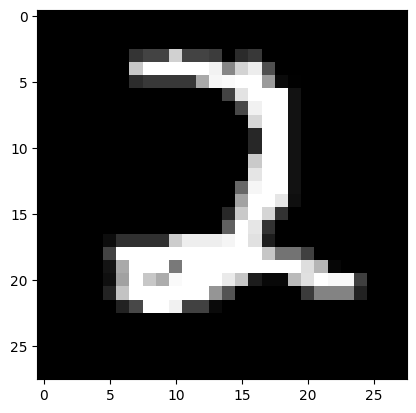

In [ ]:
import matplotlib.pyplot as plt

# let's grab the first batch and visualise the first element in the batch
_, (x, y) = next(enumerate(test_loader))
sample = x[0][0]
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(y[0].item()))
print("Shape:", x.shape, y.shape)


Now, there is one subtlety to take care of, currently, the data is set on the CPU - and we would like to move it to the GPU! We can do this as follows.

In [ ]:
print('Device before:', x.device) # still CPU
x = x.to(device) # use our 'device' object, which is the GPU
print('Device after:', x.device) # now, GPU

Device before: cpu
Device after: cuda:0


Lovely! Now we have our data working, and now how to push it to the GPU. Next, let's create a model!

## **Defining our model**



Now, it is your turn! We need a Convolutional Neural Network to do image classification. I already implement the 'forward' pass, but did not add the architecture yet! Talk through the forward function with a colleague to make sure you know what is happening.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # input channel 1, output channel 10, kernel_size 5, stride=1
        self.conv1 = nn.Conv2d(1,10,5,1)
        # input channel 10, output channel 20, kernel_size 5, stride=1
        self.conv2 = nn.Conv2d(10,20,5,1)
        # dropout layer
        self.conv2_drop = nn.Dropout()
        # fully connected layer from 320 --> 50
        self.fc1 = nn.Linear(320, 50)
        # fully connected layer from 50 --> 10
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # convolution 1
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # convolution 2
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # linear fully connected layers
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

Now, let's train this thing! I already found some hyper parameters that work. Let's first define our model, and then our optimizer. The role of the optimizer is the do the actual gradient updates of the model. Don't forget to put the model on the GPU :)!



In [ ]:
import torch.optim as optim

model = CNN()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Now, it's time to create the actually training and evaluation loop.

I want to compute per epoch how many prediction we have correct, please add that in the code where asked to!

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode (enables dropout, batch normalization, etc.)
    model.train()

    # Track cumulative loss for this epoch
    total_loss = 0
    total_samples = 0

    # Iterate through batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the specified device (CPU or GPU)
        data, target = data.to(device), target.to(device)

        # Clear gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        output = model(data)

        # Calculate loss between predictions and targets
        # using negative log-likelihood loss (common for classification)
        loss = F.nll_loss(output, target)

        # Backward pass: compute gradients of the loss w.r.t. model parameters
        loss.backward()

        # Update model parameters based on computed gradients
        optimizer.step()

        # Accumulate loss and count samples
        total_loss += loss.item() * data.size(0)
        total_samples += data.size(0)

    # Calculate and print average loss for the entire epoch
    avg_loss = total_loss / total_samples
    print(f'Train Epoch: {epoch} completed\tAverage Loss: {avg_loss:.6f}')

def test(model, device, test_loader):
    # Set the model to evaluation mode (disables dropout, uses running stats for batch norm)
    model.eval()

    # Initialize metrics
    test_loss = 0
    correct = 0

    # Disable gradient computation for efficiency during inference
    with torch.no_grad():
        # Iterate through batches of test data
        for data, target in test_loader:
            # Move data to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)

            # Forward pass: compute model predictions
            output = model(data)

            # Accumulate the sum of losses for all batches
            # reduction='sum' ensures we're summing, not averaging within this batch
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Find the index of the max log-probability (predicted class)
            pred = output.argmax(dim=1, keepdim=True)

            # TODO: IMPLEMENT THIS - Count the number of correct predictions
            # Hint: Compare predictions (pred) with targets and sum the matches

            m = (pred == target.view_as(pred)).sum()
            correct = correct + m.item()

    # Normalize the total loss by the dataset size
    test_loss /= len(test_loader.dataset)

    # Print test results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now, train the model for 5 epochs. You should get an accuracy of around 90%!

In [ ]:
# Do it here!

for epoch in range(1, 6):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

<ipython-input-12-3085cc4dec49>:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 completed	Average Loss: 0.128580

Test set: Average loss: 0.1159, Accuracy: 9712/10000 (97%)

Train Epoch: 2 completed	Average Loss: 0.126595

Test set: Average loss: 0.1130, Accuracy: 9734/10000 (97%)

Train Epoch: 3 completed	Average Loss: 0.123900

Test set: Average loss: 0.1083, Accuracy: 9762/10000 (98%)

Train Epoch: 4 completed	Average Loss: 0.125407

Test set: Average loss: 0.1185, Accuracy: 9708/10000 (97%)

Train Epoch: 5 completed	Average Loss: 0.122412

Test set: Average loss: 0.1059, Accuracy: 9751/10000 (98%)



Last but not least, I created some code to visualise the predictions! Let's see what you worked towards. Do the mistakes the model made make sense to you?

<ipython-input-12-3085cc4dec49>:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


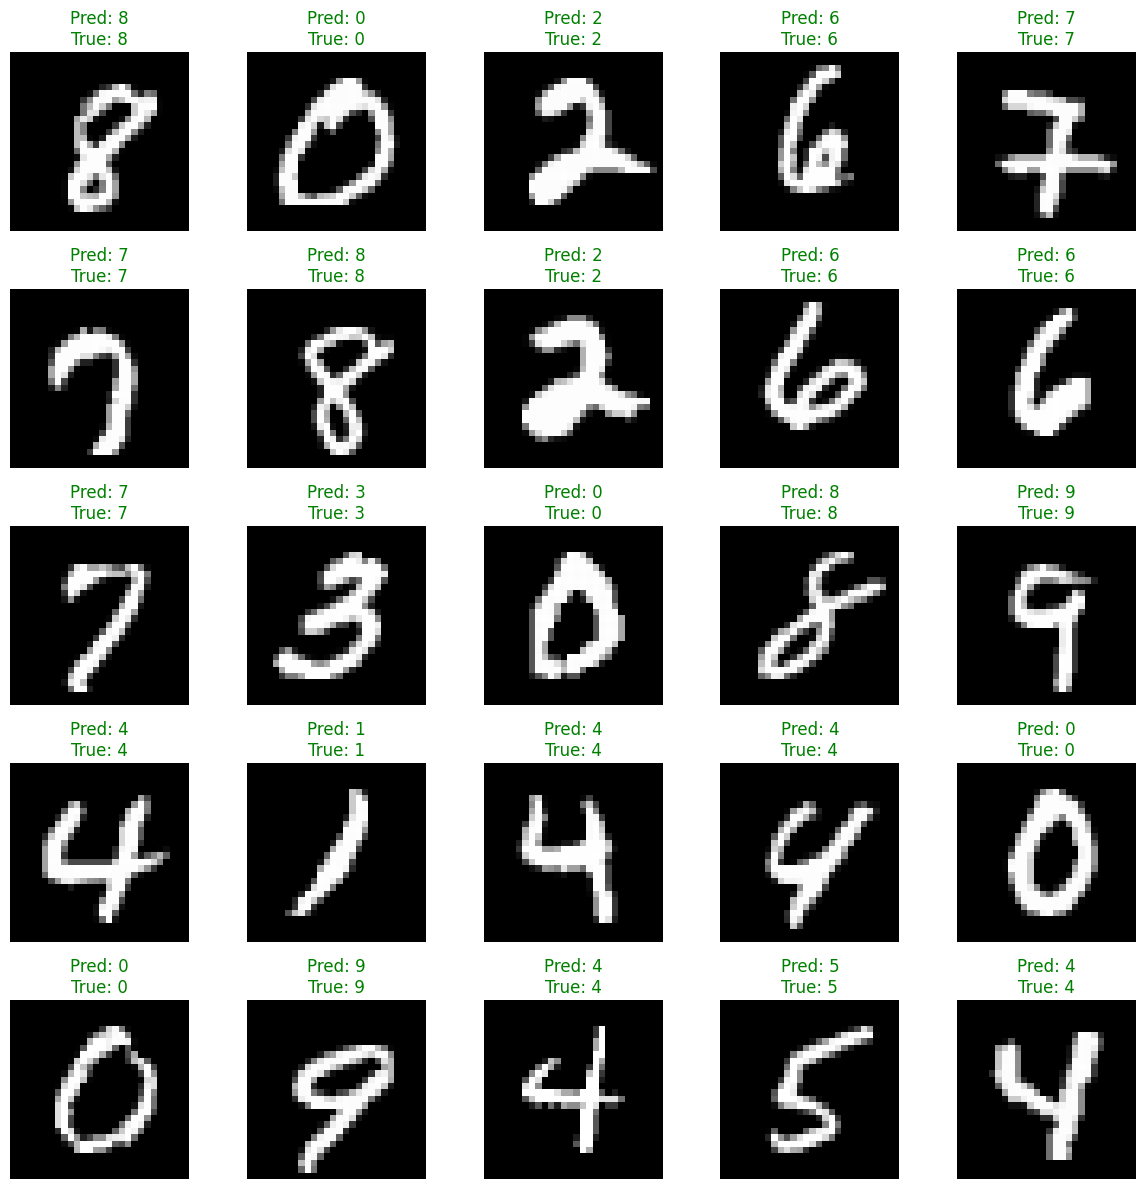

In [ ]:
# Set model to evaluation mode
model.eval()

# Disable gradients for inference
with torch.no_grad():
    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Make predictions
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move data back to CPU for plotting
    images = images.cpu()
    predicted = predicted.cpu()

    # Create a figure
    plt.figure(figsize=(12, 12))

    # Plot up to num_rows*num_cols images
    num_images = min(25, len(images))

    for i in range(25):
        # Get the correct subplot
        plt.subplot(5, 5, i + 1)

        # Display the image
        # Note: Adjust the following line based on your specific dataset
        # For MNIST:
        plt.imshow(images[i].squeeze(), cmap='gray')
        # For RGB images:
        # plt.imshow(np.transpose(images[i], (1, 2, 0)))

        # Add title showing prediction and actual label
        plt.title(f'Pred: {predicted[i]}\nTrue: {labels[i]}',
                  color=('green' if predicted[i] == labels[i] else 'red'))

        # Turn off axis
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# **Solutions**



```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


correct += pred.eq(target.view_as(pred)).sum().item()```

